# Structure Learning

## Set sys vars

In [1]:
import os,sys
from pathlib import Path
currentdir = Path(os.getcwd())
sys.path.insert(0, os.path.dirname(currentdir.parent))
sys.path.insert(0, os.path.dirname(currentdir))
print(str(sys.path[0:3]))

['C:\\Users\\Roman\\Desktop\\GitBamt\\BAMT', 'C:\\Users\\Roman\\Desktop\\GitBamt', 'C:\\Users\\Roman\\Desktop\\GitBamt\\BAMT\\tutorials']


## Import modules

In [2]:
%%time
%matplotlib inline
import BAMT.Networks as Nets
import BAMT.Preprocessors as pp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from pgmpy.estimators import K2Score

Wall time: 5.66 s


## Preprocessing

In [3]:
hack = pd.read_csv(r'../Data/hack_processed_with_rf.csv')

In [4]:
cols = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Gross','Netpay','Porosity','Permeability', 'Depth']
hack = hack[cols]

In [5]:
encoder = preprocessing.LabelEncoder()
discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

p = pp.Preprocessor([('encoder', encoder), ('discretizer', discretizer)])
discretized_data, est = p.apply(hack)

## Initializing Bayessian Network

<p> There are 3 type of Bayessian Networks - DiscreteBN, ContinuousBN, HybridBN. <br>
Note that if you pass discrete data to Continoust BN, you get an error.<br><br>
For ContinousBN user can choose whether use mixture nodes or not, for Hybrid user can restrict/allow using logit/mixture nodes.<p> 

In [6]:
bn = Nets.HybridBN(has_logit=True, use_mixture=True) # init BN
info = p.info # map for nodes (Dict["types": Dict[node_name: type], "signs": Dict[node_name: sign]])

In [7]:
from sklearn.tree import DecisionTreeClassifier
bn.add_nodes(info)
bn.add_edges(discretized_data, scoring_function=('MI',)) # use mutual information sf implemented in BAMT

In [8]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,Tectonic regime,Discrete,disc,[],[]
1,Period,ConditionalLogit (LogisticRegression),disc,"[Depth, Structural setting, Lithology]","[cont, disc, disc]"
2,Lithology,ConditionalLogit (LogisticRegression),disc,"[Netpay, Structural setting]","[cont, disc]"
3,Structural setting,Logit (LogisticRegression),disc,[Permeability],[cont]
4,Gross,MixtureGaussian,cont,[Porosity],[cont]
5,Netpay,MixtureGaussian,cont,[Permeability],[cont]
6,Porosity,ConditionalMixtureGaussian,cont,[Tectonic regime],[disc]
7,Permeability,MixtureGaussian,cont,[Gross],[cont]
8,Depth,MixtureGaussian,cont,[Gross],[cont]


In [9]:
bn.set_classifiers(classifiers={'Structural setting': DecisionTreeClassifier()})
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,Tectonic regime,Discrete,disc,[],[]
1,Period,ConditionalLogit (LogisticRegression),disc,"[Depth, Structural setting, Lithology]","[cont, disc, disc]"
2,Lithology,ConditionalLogit (LogisticRegression),disc,"[Netpay, Structural setting]","[cont, disc]"
3,Structural setting,Logit (DecisionTreeClassifier),disc,[Permeability],[cont]
4,Gross,MixtureGaussian,cont,[Porosity],[cont]
5,Netpay,MixtureGaussian,cont,[Permeability],[cont]
6,Porosity,ConditionalMixtureGaussian,cont,[Tectonic regime],[disc]
7,Permeability,MixtureGaussian,cont,[Gross],[cont]
8,Depth,MixtureGaussian,cont,[Gross],[cont]


In [10]:
bn.plot('Test1')

2022-02-05 17:33:42,923 | ERROR    | Networks.py-plot-0333 | This version allows only html format.


In [11]:
# Now let's plot graph
bn.plot('Simple.html')

## Parameters in structure learning

<p> There are 4 parameters user can tune: init_nodes, init_edges, white_list, remove_init_edges. <p>

### Init_nodes

This one defines root nodes (thus they haven't parents at all).

In [12]:
print(bn.nodes_names) # bn.nodes: List[Nodes]

['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']


In [13]:
params = {'init_nodes': ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Gross']}
bn.add_edges(discretized_data, scoring_function=('MI',), params=params)
bn.plot('init_nodes.html')

### Init_edges

<p> This one defines edges from which learning procedure starts <p>

In [14]:
params = {'init_nodes': ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Gross'],
          'init_edges':[('Period', 'Permeability'), ('Structural setting', 'Netpay'), ('Gross', 'Permeability')],}
bn.add_edges(discretized_data, scoring_function=('MI',), params=params)
bn.plot('init_edges.html')

### white_list

Strictly set edges where algoritm must learn

In [15]:
params = {'init_nodes': ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Gross'],
         'white_list': [('Period', 'Permeability'), ('Structural setting', 'Netpay'), ('Gross', 'Permeability')]}
bn.add_edges(discretized_data, scoring_function=('MI',), params=params)
bn.plot('whihe_list.html')

### Remove_init_edges

Allow algorithm to remove edges defined by user.

In [16]:
params = {'init_nodes': ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Gross'],
          'init_edges':[('Period', 'Permeability'), ('Structural setting', 'Netpay'), ('Gross', 'Permeability')],
         'remove_init_edges':True}
bn.add_edges(discretized_data, scoring_function=('MI',), params=params)
bn.plot('remove_init.html')

## Parameters Learning

<p> The second stage of learning is related to parameters, user should call fit_parameters method. <br>
    In this procedure each vertex calls its own parameters_learning method and write down an outcome into distributions in bayessian network object. <br><br>

What is going on inside each type of vertex can be found in special notebook ("Nodes.ipynb") <p>

### Sample() function

In [17]:
bn.sample(10) # no way to sample from parametrically unfitted network 

2022-02-05 17:33:47,569 | ERROR    | Networks.py-sample-0222 | Parameter learning wasn't done. Call fit_parameters method


Let's train two networks and compare their results.

In [18]:
bn_1 = Nets.HybridBN(has_logit=True, use_mixture=False)
d = p.info
bn_1.add_nodes(d)

In [19]:
bn_2 = Nets.HybridBN(has_logit=True, use_mixture=False)
d = p.info
bn_2.add_nodes(d)

In [20]:
bn_1.add_edges(discretized_data, scoring_function=('MI',))
bn_1.set_classifiers(classifiers={'Structural setting': DecisionTreeClassifier(),
                                 'Lithology': RandomForestClassifier(),
                                 'Period': KNeighborsClassifier(n_neighbors=2)})

bn_2.add_edges(discretized_data, scoring_function=('K2',K2Score))

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [21]:
bn_1.get_info()

,name,node_type,data_type,parents,parents_types
0,Tectonic regime,Discrete,disc,[],[]
1,Period,ConditionalLogit (KNeighborsClassifier),disc,"[Depth, Structural setting, Lithology]","[cont, disc, disc]"
2,Lithology,ConditionalLogit (RandomForestClassifier),disc,"[Netpay, Structural setting]","[cont, disc]"
3,Structural setting,Logit (DecisionTreeClassifier),disc,[Permeability],[cont]
4,Gross,Gaussian,cont,[Porosity],[cont]
5,Netpay,Gaussian,cont,[Permeability],[cont]
6,Porosity,ConditionalGaussian,cont,[Tectonic regime],[disc]
7,Permeability,Gaussian,cont,[Gross],[cont]
8,Depth,Gaussian,cont,[Gross],[cont]


In [22]:
bn_2.get_info()

,name,node_type,data_type,parents,parents_types
0,Tectonic regime,Discrete,disc,[],[]
1,Period,Discrete,disc,[Structural setting],[disc]
2,Lithology,Discrete,disc,[],[]
3,Structural setting,Discrete,disc,[Tectonic regime],[disc]
4,Gross,ConditionalGaussian,cont,"[Period, Lithology, Structural setting]","[disc, disc, disc]"
5,Netpay,Gaussian,cont,[Gross],[cont]
6,Porosity,ConditionalGaussian,cont,[Period],[disc]
7,Permeability,ConditionalGaussian,cont,"[Porosity, Lithology]","[cont, disc]"
8,Depth,ConditionalGaussian,cont,"[Porosity, Structural setting]","[cont, disc]"


In [23]:
%%time
bn_1.fit_parameters(hack)

2022-02-05 17:33:53,216 | WARNING  | Nodes.py-fit_parameters-0616 | Lithology ['FORELAND']::Pickle failed. BAMT will use Joblib. | invalid load key, '\x00'.
Wall time: 3.35 s


In [24]:
%%time
bn_2.fit_parameters(hack)

Wall time: 8.77 s


In [25]:
bn_1.get_params_tree('out.json')

True

In [26]:
%%time
synth_data_mi = bn_1.sample(514, as_df=True)

Wall time: 21.4 s


In [27]:
%%time
synth_data_k2 = bn_2.sample(514, as_df=True)

Wall time: 114 ms


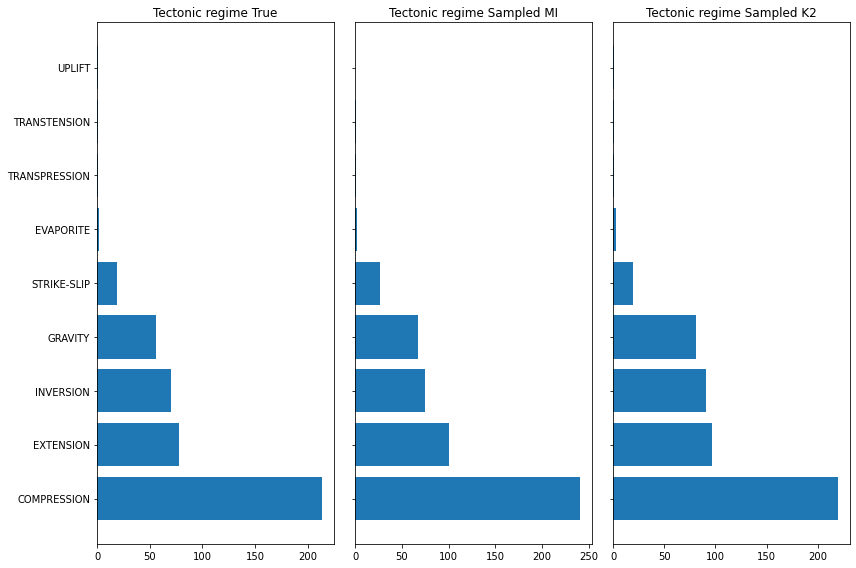

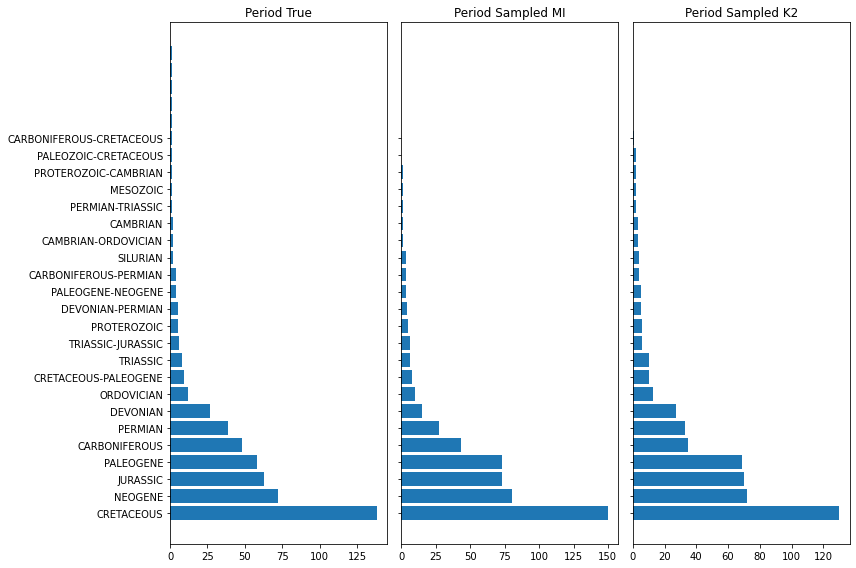

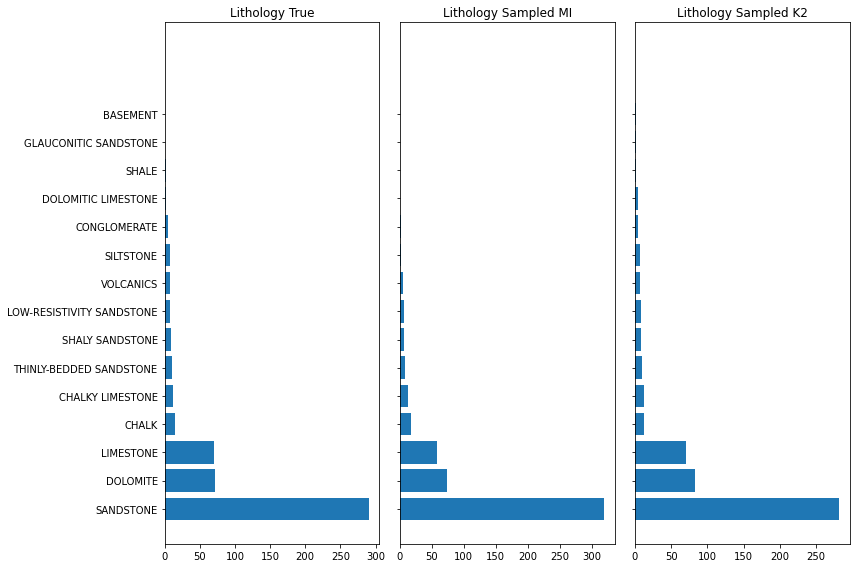

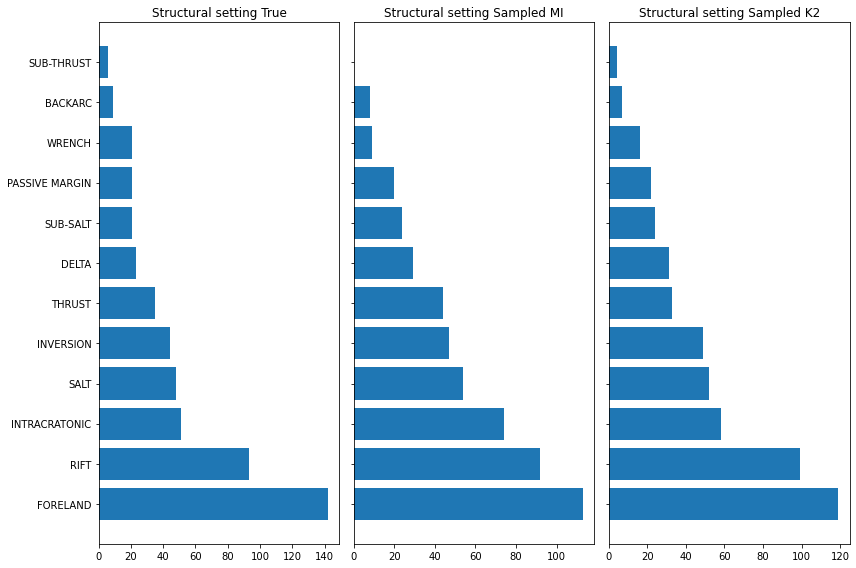

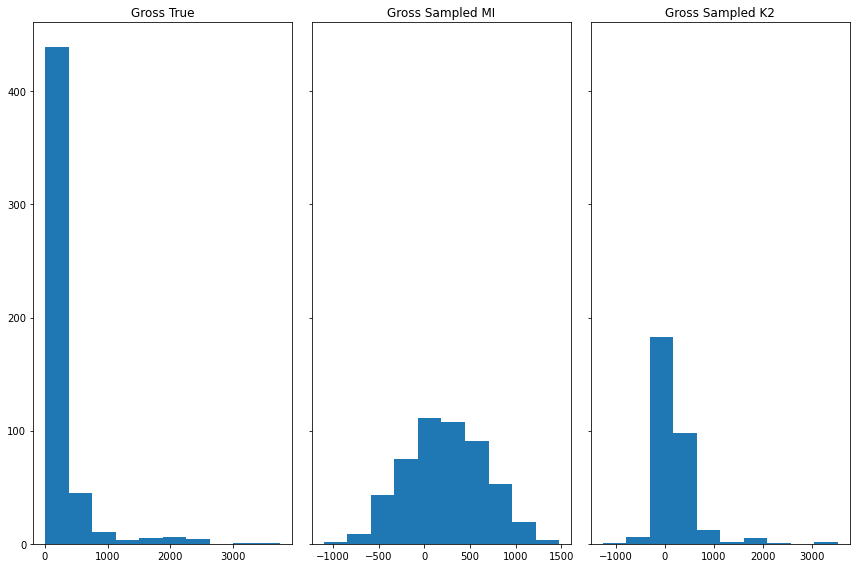

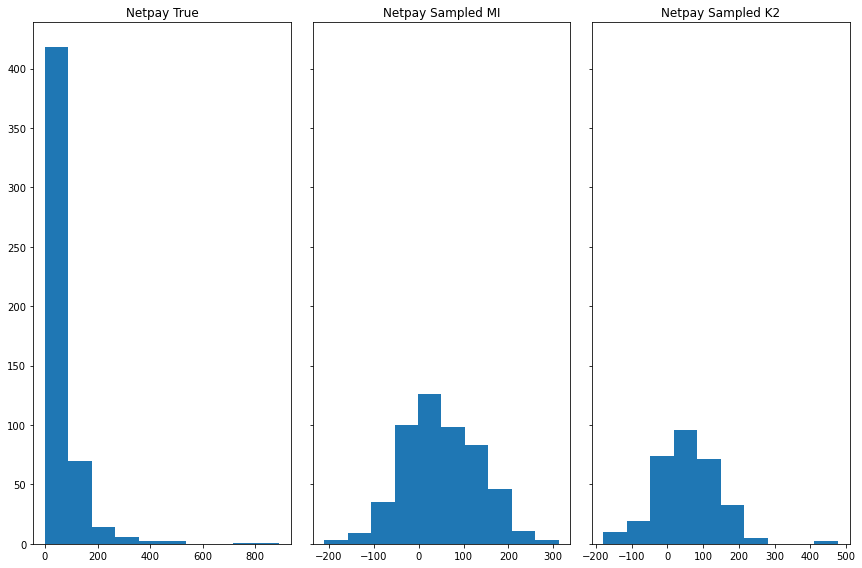

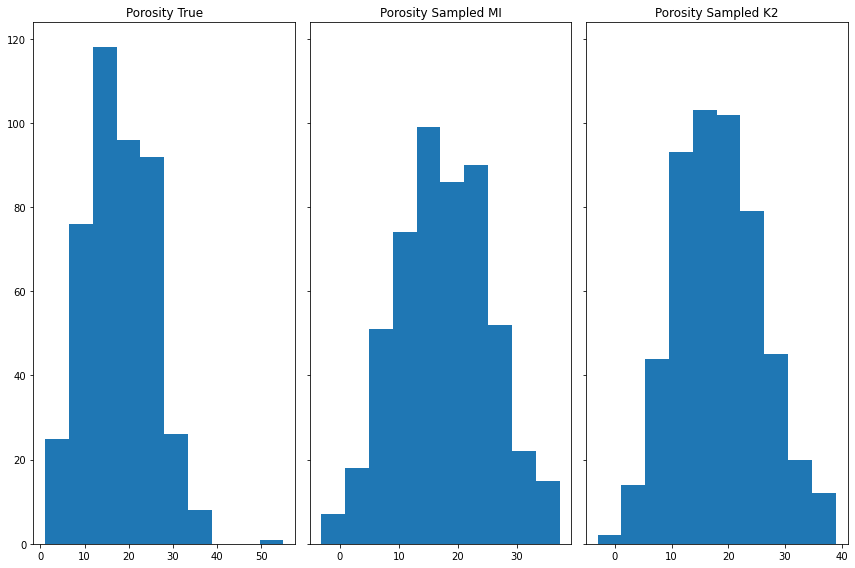

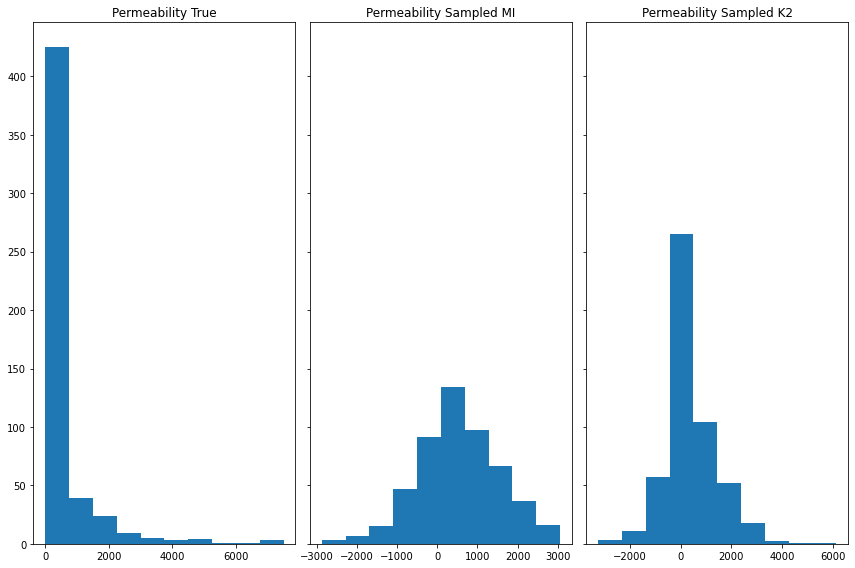

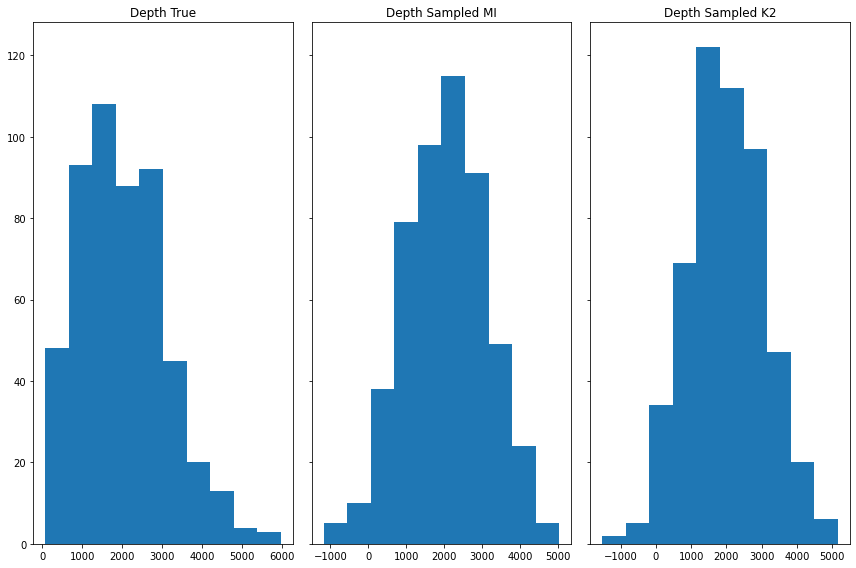

In [28]:
for column in hack.columns.to_list():
    fig, ax = plt.subplots(1,3, figsize=(12,8), sharey=True)
    if hack[column].dtype.name in ['float64']:
        ax[0].hist(hack[column].values)
        ax[1].hist(synth_data_mi[column].values)
        ax[2].hist(synth_data_k2[column].values)
    else:
        ax[0].barh(hack[column].value_counts().index, hack[column].value_counts().values)
        ax[1].barh(synth_data_mi[column].value_counts().index, synth_data_mi[column].value_counts().values)
        ax[2].barh(synth_data_k2[column].value_counts().index, synth_data_k2[column].value_counts().values)
    ax[0].set_title(f'{column} True')
    ax[1].set_title(f'{column} Sampled MI')
    ax[2].set_title(f"{column} Sampled K2")
    
    plt.tight_layout()

___
## Predict() function

#### Preparartions

In [29]:
d = p.info

bn_1 = Nets.HybridBN()
bn_1.add_nodes(d)

In [30]:
bn_2 = Nets.HybridBN()
bn_2.add_nodes(d)

In [31]:
bn_1.add_edges(discretized_data, scoring_function=('MI',))
bn_2.add_edges(discretized_data, scoring_function=('K2',K2Score))

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [32]:
bn_1.get_info(as_df=True)

,name,node_type,data_type,parents,parents_types
0,Tectonic regime,Discrete,disc,[],[]
1,Period,ConditionalLogit (LogisticRegression),disc,"[Depth, Structural setting, Lithology]","[cont, disc, disc]"
2,Lithology,ConditionalLogit (LogisticRegression),disc,"[Netpay, Structural setting]","[cont, disc]"
3,Structural setting,Logit (LogisticRegression),disc,[Permeability],[cont]
4,Gross,Gaussian,cont,[Porosity],[cont]
5,Netpay,Gaussian,cont,[Permeability],[cont]
6,Porosity,ConditionalGaussian,cont,[Tectonic regime],[disc]
7,Permeability,Gaussian,cont,[Gross],[cont]
8,Depth,Gaussian,cont,[Gross],[cont]


In [33]:
bn_2.get_info(as_df=True)

,name,node_type,data_type,parents,parents_types
0,Tectonic regime,Discrete,disc,[],[]
1,Period,Discrete,disc,[Structural setting],[disc]
2,Lithology,Discrete,disc,[],[]
3,Structural setting,Discrete,disc,[Tectonic regime],[disc]
4,Gross,ConditionalGaussian,cont,"[Period, Lithology, Structural setting]","[disc, disc, disc]"
5,Netpay,Gaussian,cont,[Gross],[cont]
6,Porosity,ConditionalGaussian,cont,[Period],[disc]
7,Permeability,ConditionalGaussian,cont,"[Porosity, Lithology]","[cont, disc]"
8,Depth,ConditionalGaussian,cont,"[Porosity, Structural setting]","[cont, disc]"


In [34]:
%%time
bn_1.fit_parameters(hack)

Wall time: 7.8 s


In [35]:
%%time
bn_2.fit_parameters(hack)

Wall time: 9.51 s


User can use bn.predict() to get predictions according to train data. Note that predict is async function so user can set a number of threads. It is more accurate due to dealing with signs but it can take a long time. <br>
Performance time can increase because of:
1. Logit Nodes with big models
2. Mixture Nodes
3. Problems with serialization (Joblib is slower than Pickle) 
<br><br>
For more details, check TimeComparison.ipynb.
**Since each continuous node trains a distribution, sample value can be negative while a train variable itself doesn't.**<br>
Predict requires a test dataset, train dataset without testing columns (nodes).

In [44]:
hack_filtered = hack.dropna()
hack_filtered

,Tectonic regime,Period,Lithology,Structural setting,Gross,Netpay,Porosity,Permeability,Depth
0,COMPRESSION,JURASSIC,LIMESTONE,FORELAND,75.0,55.2,21.0,410.0,1815.0
1,EXTENSION,CRETACEOUS,SANDSTONE,RIFT,223.5,43.2,10.0,8.0,3084.6
2,STRIKE-SLIP,NEOGENE,THINLY-BEDDED SANDSTONE,WRENCH,34.5,19.8,22.0,200.0,2952.9
3,STRIKE-SLIP,NEOGENE,SANDSTONE,WRENCH,152.7,123.0,20.0,300.0,3149.7
4,COMPRESSION,CRETACEOUS,LIMESTONE,SALT,75.0,30.0,21.0,60.0,1486.5
...,...,...,...,...,...,...,...,...,...
507,EXTENSION,PALEOGENE,SANDSTONE,RIFT,69.0,20.7,26.7,1872.0,1615.2
509,EXTENSION,PALEOGENE,SANDSTONE,RIFT,49.2,18.6,23.2,121.0,1416.3
511,EXTENSION,MESOZOIC,VOLCANICS,RIFT,147.6,58.2,12.7,3.6,2952.9
512,COMPRESSION,CARBONIFEROUS,SANDSTONE,FORELAND,78.6,9.9,24.0,30.0,561.0


In [45]:
columns = ['Lithology', 'Structural setting', 'Porosity', 'Depth']
validY = hack_filtered[columns]
validX = hack_filtered.drop(columns, axis=1)

In [46]:
%%time
predictions_mi = bn_1.predict(test=validX, parall_count=3)

100%|██████████| 442/442 [25:14<00:00,  3.43s/it]


Wall time: 25min 45s


In [47]:
%%time
predictions_k2 = bn_2.predict(test=validX, parall_count=3)

100%|██████████| 442/442 [06:11<00:00,  1.19it/s]


Wall time: 6min 15s


In [83]:
# Bn_1 Metrics
for column in columns:
    if bn_1.descriptor['types'][column] == 'cont':
        print(f"{column: <25} MSE: {round(mean_squared_error(validY[column], predictions_mi[column], squared=False), 10): >13}")
    else:
        print(f"{column: <25} Accuracy:  {round(accuracy_score(validY[column], predictions_mi[column]), 10)}")

Lithology                 Accuracy:  0.5610859729
Structural setting        Accuracy:  0.0180995475
Porosity                  MSE:  7.5495339634
Depth                     MSE: 1074.3471603141


In [84]:
# Bn_1 Metrics
for column in columns:
    if bn_2.descriptor['types'][column] == 'cont':
        print(f"{column: <25} MSE: {round(mean_squared_error(validY[column], predictions_k2[column], squared=False), 10): >13}")
    else:
        print(f"{column: <25} Accuracy:  {round(accuracy_score(validY[column], predictions_k2[column]), 10)}")

Lithology                 Accuracy:  0.5610859729
Structural setting        Accuracy:  0.2760180995
Porosity                  MSE:  7.5496374869
Depth                     MSE: 1076.1643805127
